In [21]:
import torch

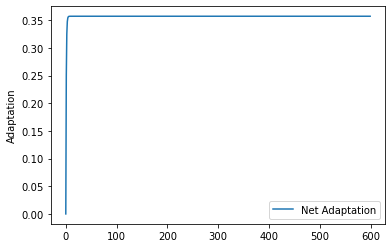

In [84]:
import matplotlib.pyplot as plt

# Set the number of trials to simulate
num_trials = 599

# Set the initial value for the state variable
x = 0

# Set the learning rate
A = 0.8
B = 0.5

# Set the target position for the experiment
target_position = 0.5

# Create an empty list to store the values of x(n) on each trial
x_list = []
x_list.append(x)
# Simulate the progression of x(n) over the specified number of trials
for n in range(num_trials):

    # Compute the error on this trial
    e = target_position - x

    # Compute x(n+1) according to the learning rule
    x = A * x + B * e

    # Store the value of x(n) in the list
    x_list.append(x)

# Print the final value of x(n)
# print("Final value of x(n):", x_list[-1])
# print(x_list)
plt.plot(x_list, label="Net Adaptation")
plt.ylabel("Adaptation")
plt.legend()
plt.show()

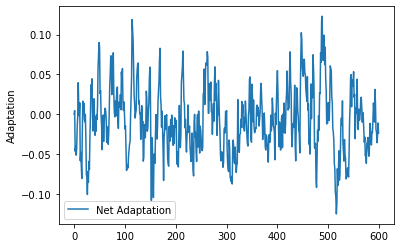

[0, 0.004503068364668457, -0.04645273997341571, -0.04034879795330195, -0.051307418027265246, -0.04224221482978899, -0.014799825304048223, -0.003253717544276861, 0.03960920749771767, 0.010999906484225396, -0.001814428342760889, 0.014380821880058825, -0.058261799621677, -0.047672045383039194, -0.06510422192333945, -0.08067959936675834, -0.023153436856277826, 0.016505575023654784, 0.001502643879460688, 0.014059777588015038, -0.006080319366250062, -0.009569225480249554, 1.9658177411154866e-05, -0.029327918681081037, -0.075631020447075, -0.07927504794090388, -0.10070839132259277, -0.07178043706259236, -0.0852508233654496, -0.059121270993560994, -0.06924823738213562, -0.02870287744045092, -0.0030361560564064506, 0.03691782103524944, 0.028126194852218206, 0.04459687239625945, 0.0034129488207446587, -0.02099873632532091, -0.014310797670157882, 0.01949639507237285, -0.004848071433726644, -0.026357371872179243, -0.003313998760110244, -0.021320556399806043, -0.0007064397718788695, -0.006310384715

In [85]:
import matplotlib.pyplot as plt
import random
# Set the number of trials to simulate
num_trials = 599

# Set the initial value for the state variable
x_noise = 0

# Set the learning rate
A = 0.8
B = 0.5

# Set the target position for the experiment
target_position = 0.5

# Create an empty list to store the values of x(n) on each trial
x_list_noise = []
x_list_noise.append(x_noise)
# Simulate the progression of x(n) over the specified number of trials
for n in range(num_trials):

    # Compute the error on this trial
    e_noise = random.gauss(0, 0.05)

    # Compute x(n+1) according to the learning rule
    x_noise = A * x_noise + B * e_noise

    # Store the value of x(n) in the list
    x_list_noise.append(x_noise)

# Print the final value of x(n)
# print("Final value of x(n):", x_list[-1])
# print(x_list)
plt.plot(x_list_noise, label="Net Adaptation")
plt.ylabel("Adaptation")
plt.legend()
plt.show()
x_s=x_list_noise
print(x_s)

In [86]:
len(x_s)

600

In [92]:
data_index=[i for i in range(600)]
data_index_t=torch.tensor(data_index, dtype=torch.float)
data_s=torch.tensor(x_s, dtype=torch.float)
import pyro
import pyro.distributions as dist

def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    beta = pyro.sample("beta", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    noise=pyro.sample("error",dist.Normal(0,0.05))

    mean = alpha*x + beta * noise

    with pyro.plate("data", 600):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
# pyro.render_model(model, model_args=(data_index_t, data_list_t), render_distributions=True)
def guide(x,y):
    
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0))
    beta_q = pyro.param("beta_q", torch.tensor(1.0))
    sigma_q = pyro.param("sigma_q", torch.tensor(1.0))
    noise_q = pyro.param("noise_q", torch.tensor(1.0))
    sigma=pyro.sample("y", dist.Normal(alpha_q * x+ beta_q*noise_q , sigma_q))
    
    alpha_scale = pyro.param('alpha_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    beta_scale = pyro.param('beta_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    noise_scale = pyro.param('noise_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    alpha = pyro.sample("alpha", dist.Normal(alpha_q, alpha_scale))
    beta = pyro.sample("beta", dist.Normal(beta_q, beta_scale))
    noise=pyro.sample("noise", dist.Normal(noise_q, noise_scale))
    
    return {"alpha": alpha, "beta": beta, "sigma": sigma, "noise": noise}

In [93]:
import logging
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(600):  # Consider running for more steps.
    loss = svi.step(data_index_t, data_s)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

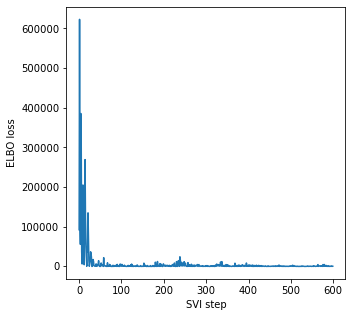

In [94]:
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [95]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.0015388964
AutoNormal.scales.alpha 0.00039160097
AutoNormal.locs.beta -0.070663296
AutoNormal.scales.beta 0.44955173
AutoNormal.locs.sigma -1.4374473
AutoNormal.scales.sigma 0.0390928
AutoNormal.locs.error -0.01701387
AutoNormal.scales.error 0.036776617


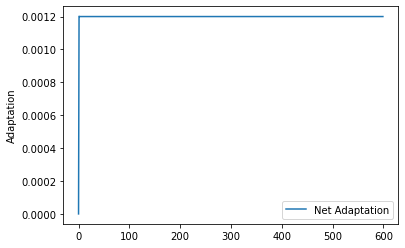

In [126]:
# Set the number of trials to simulate
num_trials = 599

# Set the initial value for the state variable
x_noise = 0

# Set the learning rate
A = -0.0015388964
B =  -0.070663296

# Set the target position for the experiment
target_position = 0.5

# Create an empty list to store the values of x(n) on each trial
x_list_noise = []
x_list_noise.append(x_noise)
# Simulate the progression of x(n) over the specified number of trials
for n in range(num_trials):

    # Compute the error on this trial
    e_noise = -0.01701387

    # Compute x(n+1) according to the learning rule
    x_noise = A * x_noise + B * e_noise

    # Store the value of x(n) in the list
    x_list_noise.append(x_noise)

# Print the final value of x(n)
# print("Final value of x(n):", x_list[-1])
# print(x_list)
plt.plot(x_list_noise, label="Net Adaptation")
plt.ylabel("Adaptation")
plt.legend()
plt.show()


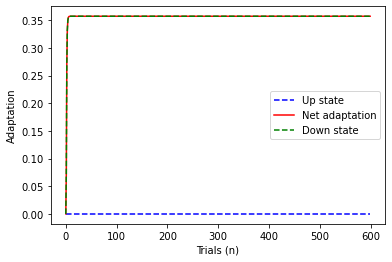

In [97]:
import matplotlib.pyplot as plt

# Set the number of trials to simulate
num_trials = 599

# Set the initial values for the gain-specific model
x1 = 0
x2 = 0
A = 0.8
B = 0.5

# Set the target position for the experiment
target_position = 0.5

# Create empty lists to store the values of x1(n), x2(n), and x(n) on each trial
x1_list = []
x1_list.append(x1)
x2_list = []
x2_list.append(x2)
x_list = []
x_list.append(x1+x2)
# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e = target_position - x

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1 = min(0, (A * x1 + B * e))
    x2 = max(0, (A * x2 + B * e))

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x = x1 + x2

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list.append(x1)
    x2_list.append(x2)
    x_list.append(x)
# Plot the progression of x1(n), x2(n), and x(n) over the trials
plt.plot(x1_list, "b--", label="Up state")#range(num_trials), 
plt.plot(x_list, "r-", label="Net adaptation")
plt.plot(x2_list, "g--", label="Down state")
plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()


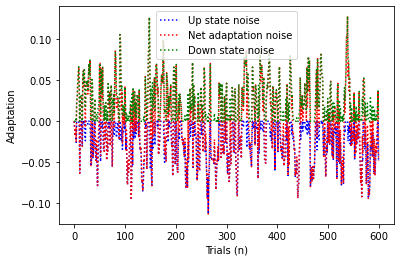

[0, -0.008364247277412728, -0.01789443099497205, -0.007864412670388935, -0.02565946457404797, 0.023888719800341126, 0.027843648141292747, 0.04528305726207856, 0.056105150691734315, 0.06620500359380199, 0.044616954708140595, -0.06306202015262548, 0.0138485834038828, 0.020078879497963352, 0.029660293280875407, 0.02992419472205143, -0.030634403745537164, 0.05382304321458773, 0.06114434561581747, 0.042097652321531086, 0.06259219802273683, 0.017320909192128336, -0.0074559759632448, 0.0405043225750154, 0.04903011912097417, 0.044057377801732384, 0.050065366676793316, 0.033036007829982804, 0.05061844764553547, 0.06986423007047424, 0.05586602212803447, 0.07447012857099475, 0.029116885229274768, -0.054563858063395525, -0.05033300912780849, 0.05064565289682363, 0.04375016711010232, -0.04427870935599902, -0.03647818744294829, -0.03185001990980316, 0.013453004766513808, 0.027388239848509965, -0.034658116869768295, -0.047821436960804896, -0.021920913056684733, -0.05197629048183578, -0.07820295702364

In [98]:
import matplotlib.pyplot as plt
import numpy as np
# Set the number of trials to simulate
num_trials =599
A = 0.8
B = 0.5

# Set the target position for the experiment
target_position = 0.5
#generate noise data   
x1_noise = 0
x2_noise = 0
x1_list_noise = []
x1_list_noise.append(x1_noise)
x2_list_noise = []
x2_list_noise.append(x2_noise)
x_list_noise = []
x_list_noise.append(x1_noise+x2_noise)
for n in range(num_trials):

    # Compute the error on this trial
    e_noise = random.gauss(0, 0.05)

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1_noise = min(0, (A * x1_noise + B * e_noise))
    x2_noise = max(0, (A * x2_noise + B * e_noise))

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x_noise = x1_noise + x2_noise

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list_noise.append(x1_noise)
    x2_list_noise.append(x2_noise)
    x_list_noise.append(x_noise)


plt.plot(x1_list_noise, "b:", label="Up state noise")#range(num_trials), 
plt.plot(x_list_noise, "r:", label="Net adaptation noise")
plt.plot(x2_list_noise, "g:", label="Down state noise")

plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()

x_g=x_list_noise
print(x_g)

In [100]:
data_index=[i for i in range(600)]
data_index_t=torch.tensor(data_index, dtype=torch.float)
data_g=torch.tensor(x_g, dtype=torch.float)
import pyro
import pyro.distributions as dist

def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    beta = pyro.sample("beta", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    noise=pyro.sample("error",dist.Normal(0,0.05))

    mean = alpha*x + beta * noise

    with pyro.plate("data", 600):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
# pyro.render_model(model, model_args=(data_index_t, data_list_t), render_distributions=True)
def guide(x,y):
    
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0))
    beta_q = pyro.param("beta_q", torch.tensor(1.0))
    sigma_q = pyro.param("sigma_q", torch.tensor(1.0))
    noise_q = pyro.param("noise_q", torch.tensor(1.0))
    sigma=pyro.sample("y", dist.Normal(alpha_q * x+ beta_q*noise_q , sigma_q))
    
    alpha_scale = pyro.param('alpha_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    beta_scale = pyro.param('beta_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    noise_scale = pyro.param('noise_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    alpha = pyro.sample("alpha", dist.Normal(alpha_q, alpha_scale))
    beta = pyro.sample("beta", dist.Normal(beta_q, beta_scale))
    noise=pyro.sample("noise", dist.Normal(noise_q, noise_scale))
    
    return {"alpha": alpha, "beta": beta, "sigma": sigma, "noise": noise}

In [101]:
import logging
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(600):  # Consider running for more steps.
    loss = svi.step(data_index_t, data_g)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

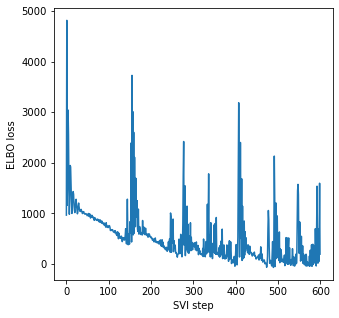

In [102]:
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [103]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.0010248022
AutoNormal.scales.alpha 7.54321e-05
AutoNormal.locs.beta 0.008263469
AutoNormal.scales.beta 0.40549126
AutoNormal.locs.sigma -3.2963994
AutoNormal.scales.sigma 0.03407421
AutoNormal.locs.error 0.07291476
AutoNormal.scales.error 0.04104075


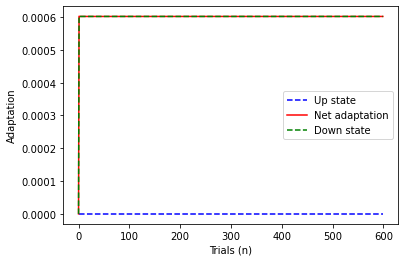

In [104]:
# Set the number of trials to simulate
num_trials = 599

# Set the initial values for the gain-specific model
x1 = 0
x2 = 0
A = -0.0010248022
B = 0.008263469

# Set the target position for the experiment
target_position = 0.5

# Create empty lists to store the values of x1(n), x2(n), and x(n) on each trial
x1_list = []
x1_list.append(x1)
x2_list = []
x2_list.append(x2)
x_list = []
x_list.append(x1+x2)
# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e = 0.07291476

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1 = min(0, (A * x1 + B * e))
    x2 = max(0, (A * x2 + B * e))

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x = x1 + x2

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list.append(x1)
    x2_list.append(x2)
    x_list.append(x)
# Plot the progression of x1(n), x2(n), and x(n) over the trials
plt.plot(x1_list, "b--", label="Up state")#range(num_trials), 
plt.plot(x_list, "r-", label="Net adaptation")
plt.plot(x2_list, "g--", label="Down state")
plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()



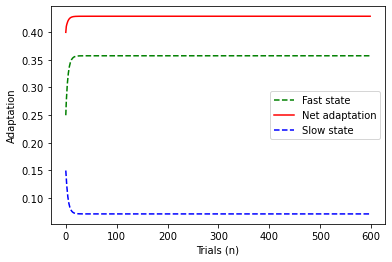

[0.3995184703854864, 0.40998796175963714, 0.4139951847038549, 0.41709626814548756, 0.41953706266935153, 0.4214586874540263, 0.42297157933652757, 0.42416267659468176, 0.42510042548238014, 0.42583871361995734, 0.426419966641142, 0.42687758617671406, 0.4272378692749599, 0.4275215195582007, 0.42774483695381094, 0.4279206543674668, 0.42805907512443525, 0.42816805355587356, 0.42825385209345446, 0.4283214011392049, 0.42837458239042936, 0.42841645190095146, 0.4284494156968568, 0.42847536803847597, 0.42849580027381223, 0.428511886538665, 0.4285245512281939, 0.42853452211716847, 0.42854237218145286, 0.42854855252399054, 0.428553418297378, 0.42855724911266246, 0.4285602651071562, 0.4285626395945983, 0.42856450902460713, 0.42856598082373965, 0.4285671395687457, 0.42856805184675917, 0.42856877008171984, 0.42856933554690824, 0.4285697807367095, 0.4285701312338985, 0.42857040717975164, 0.4285706244314623, 0.42857079547337235, 0.4285709301343833, 0.42857103615277287, 0.42857111962087446, 0.42857118533

In [109]:
import matplotlib.pyplot as plt

# Set the number of trials to simulate
num_trials = 599

# Set the initial values for the gain-specific model
x1 = 0
x2 = 0
Af = 0.9
As = 0.7
Bf = 0.5
Bs = 0.3

# Set the target position for the experiment
target_position = 0.5

# Create empty lists to store the values of x1(n), x2(n), and x(n) on each trial
x1_list = []

x2_list = []

x_list = []

# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e = target_position - x

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1 = Af * x1 + Bf * e
    x2 = As * x2 + Bs * e

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x = x1 + x2

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list.append(x1)
    x2_list.append(x2)
    x_list.append(x)
# Plot the progression of x1(n), x2(n), and x(n) over the trials
plt.plot(x1_list, "g--", label="Fast state")#range(num_trials), 
plt.plot(x_list, "r-", label="Net adaptation")
plt.plot(x2_list, "b--", label="Slow state")
plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()

print(x_list)

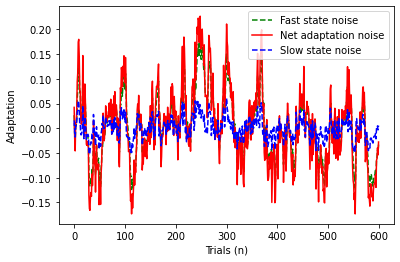

[0.04226430383685353, -0.019772596560131937, -0.04577789467184018, 0.011454301736409421, 0.011502576093772972, 0.03270483369471232, 0.09363859851416807, 0.11103074319484743, 0.17436050580866036, 0.17990068822428743, 0.1449318752279961, 0.0774344609037205, 0.07481531153034789, 0.019048441461213546, 0.00830446793888997, 0.01139674393697078, 0.02778837344632335, 0.14713524015774135, 0.07229797946618644, -0.017559960047439538, 0.057369944214930385, 0.08963620566953517, 0.05743493523745715, 0.01200149081028204, -0.03225947099131893, -0.03462381978204926, -0.02678617991854994, -0.02875986915262255, -0.042753806789754094, -0.13559805096121902, -0.16237636988870507, -0.16605533986161639, -0.1399905281943491, -0.129968400192515, -0.13771814070029423, -0.09254492863090273, -0.11591788284582205, -0.09239804405413335, 0.015091129942608611, -0.007251172451203828, -0.07144113901294724, -0.05854465128376804, -0.1290736018938416, -0.06146709615133833, -0.03337360334140189, -0.07444887318893204, -0.083

In [113]:
import matplotlib.pyplot as plt

# Set the number of trials to simulate
num_trials = 600

# Set the initial values for the gain-specific model
x1_noise = 0
x2_noise = 0
Af = 0.9
As = 0.7
Bf = 0.5
Bs = 0.3

# Set the target position for the experiment
target_position = 0.5

# Create empty lists to store the values of x1(n), x2(n), and x(n) on each trial
x1_list_noise = []

x2_list_noise = []

x_list_noise = []

# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e_noise = random.gauss(0, 0.05)

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1_noise = Af * x1_noise + Bf * e_noise
    x2_noise = As * x2_noise + Bs * e_noise

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x_noise = x1_noise + x2_noise

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list_noise.append(x1_noise)
    x2_list_noise.append(x2_noise)
    x_list_noise.append(x_noise)
# Plot the progression of x1(n), x2(n), and x(n) over the trials
plt.plot(x1_list_noise, "g--", label="Fast state noise")#range(num_trials), 
plt.plot(x_list_noise, "r-", label="Net adaptation noise")
plt.plot(x2_list_noise, "b--", label="Slow state noise")
plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()
x1_m=x1_list_noise
x2_m=x2_list_noise
x_m=x_list_noise
print(x_m)

In [118]:
data_index=[i for i in range(600)]
data_index_t=torch.tensor(data_index, dtype=torch.float)
x1_m=torch.tensor(x1_m, dtype=torch.float)
x2_m=torch.tensor(x2_m, dtype=torch.float)
import pyro
import pyro.distributions as dist

def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    beta = pyro.sample("beta", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    noise=pyro.sample("error",dist.Normal(0,0.05))

    mean = alpha*x + beta * noise

    with pyro.plate("data", 600):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
# pyro.render_model(model, model_args=(data_index_t, data_list_t), render_distributions=True)
def guide(x,y):
    
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0))
    beta_q = pyro.param("beta_q", torch.tensor(1.0))
    sigma_q = pyro.param("sigma_q", torch.tensor(1.0))
    noise_q = pyro.param("noise_q", torch.tensor(1.0))
    sigma=pyro.sample("y", dist.Normal(alpha_q * x+ beta_q*noise_q , sigma_q))
    
    alpha_scale = pyro.param('alpha_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    beta_scale = pyro.param('beta_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    noise_scale = pyro.param('noise_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    alpha = pyro.sample("alpha", dist.Normal(alpha_q, alpha_scale))
    beta = pyro.sample("beta", dist.Normal(beta_q, beta_scale))
    noise=pyro.sample("noise", dist.Normal(noise_q, noise_scale))
    
    return {"alpha": alpha, "beta": beta, "sigma": sigma, "noise": noise}

In [119]:
import logging
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(600):  # Consider running for more steps.
    loss = svi.step(data_index_t, x1_m)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

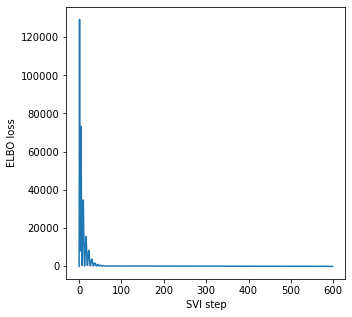

In [120]:
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [121]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -8.5186504e-05
AutoNormal.scales.alpha 5.953814e-05
AutoNormal.locs.beta -0.120553195
AutoNormal.scales.beta 0.32022762
AutoNormal.locs.sigma -3.408156
AutoNormal.scales.sigma 0.03151641
AutoNormal.locs.error 0.0008211667
AutoNormal.scales.error 0.03204312


In [122]:
import logging
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(600):  # Consider running for more steps.
    loss = svi.step(data_index_t, x2_m)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

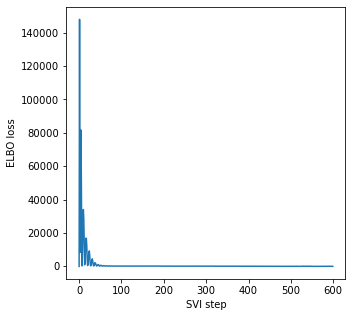

In [123]:
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [124]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.00018732106
AutoNormal.scales.alpha 5.8601472e-05
AutoNormal.locs.beta -0.076362066
AutoNormal.scales.beta 0.3402848
AutoNormal.locs.sigma -3.402016
AutoNormal.scales.sigma 0.02853525
AutoNormal.locs.error 0.005516847
AutoNormal.scales.error 0.032078415


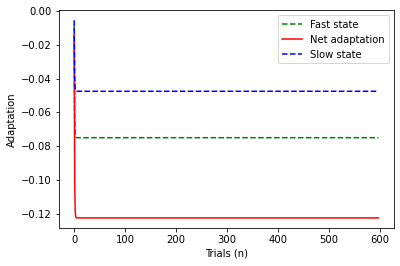

[-0.01406537578571429, -0.10122556237759453, -0.11837785628642322, -0.12175326444070378, -0.12241751263211272, -0.12254823035264394, -0.1225739543556324, -0.12257901659453206, -0.12258001279495578, -0.12258020883771553, -0.12258024741706433, -0.1225802550091129, -0.1225802565031558, -0.1225802567971692, -0.12258025685502826, -0.12258025686641437, -0.12258025686865505, -0.12258025686909599, -0.12258025686918278, -0.12258025686919985, -0.12258025686920321, -0.12258025686920386, -0.12258025686920399, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.12258025686920404, -0.1225802568

In [125]:
import matplotlib.pyplot as plt

# Set the number of trials to simulate
num_trials = 599

# Set the initial values for the gain-specific model
x1 = 0
x2 = 0
Af = -8.5186504e-05
As = -0.00018732106
Bf = -0.120553195
Bs = -0.076362066

# Set the target position for the experiment
target_position = 0.5

# Create empty lists to store the values of x1(n), x2(n), and x(n) on each trial
x1_list = []

x2_list = []

x_list = []

# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e = target_position - x

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1 = Af * x1 + Bf * e
    x2 = As * x2 + Bs * e

    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x = x1 + x2

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list.append(x1)
    x2_list.append(x2)
    x_list.append(x)
# Plot the progression of x1(n), x2(n), and x(n) over the trials
plt.plot(x1_list, "g--", label="Fast state")#range(num_trials), 
plt.plot(x_list, "r-", label="Net adaptation")
plt.plot(x2_list, "b--", label="Slow state")
plt.xlabel("Trials (n)")
plt.ylabel("Adaptation")
plt.legend()
plt.show()

print(x_list)

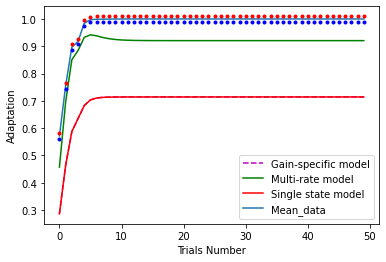

In [27]:
import numpy as np
import random
random.seed(10)
from scipy.stats import sem
import matplotlib.pyplot as plt
# Set the number of trials to simulate
num_trials = 50
data_list=[]
upper_list=[]
lower_list=[]
last_value=0

Af = 0.9
As = 0.7
Bf = 0.5
Bs = 0.3
A = 0.8
B = 0.5
x_g,x_m,x_s=0,0,0
x1_m,x2_m,x1_g,x2_g=0,0,0,0
for n in range(num_trials):
    data=random.uniform(last_value, 1)
    data_list.append(data)#generate mean data randomly
    last_value=data
for n in range(num_trials):
    upper_bound=data_list[n]+sem(data_list)
    lower_bound=data_list[n]-sem(data_list)
    upper_list.append(upper_bound)
    lower_list.append(lower_bound)
    
x1_list_m = []
x2_list_m = []
x_list_m = []
    
x1_list_g = []
x2_list_g = []
x_list_g = []

x_list_s = []
# Simulate the progression of motor output for the gain-specific model
for n in range(num_trials):

    # Compute the error on this trial
    e_m = data_list[n] - x_m
    e_g = data_list[n] - x_g
    e_s = data_list[n] - x_s

    # Compute x1(n+1) and x2(n+1) according to the learning rules
    x1_m = Af * x1_m + Bf * e_m
    x2_m = As * x2_g + Bs * e_m
    x1_g = min(0, (A * x1_g + B * e_g))
    x2_g = max(0, (A * x2_g + B * e_g))
    x_s = A * x_s + B * e_s
    # Compute x(n+1) as the sum of x1(n+1) and x2(n+1)
    x_m = x1_m + x2_m
    x_g = x1_g + x2_g

    # Store the values of x1(n), x2(n), and x(n) in the lists
    x1_list_m.append(x1_m)
    x2_list_m.append(x2_m)
    x_list_m.append(x_m)
    
    x1_list_g.append(x1_g)
    x2_list_g.append(x2_g)
    x_list_g.append(x_g)

    x_list_s.append(x_s)
plt.plot(x_list_g, "m--", label="Gain-specific model")
plt.plot(x_list_m, "g-", label="Multi-rate model")
plt.plot(x_list_s, "r-", label="Single state model")
plt.plot(data_list,'-', label='Mean_data')
plt.plot(upper_list,'r.')
plt.plot(lower_list,'b.')
plt.xlabel("Trials Number")
plt.ylabel("Adaptation")
plt.legend()
plt.show()

In [28]:

data_index=[i for i in range(50)]
data_index_t=torch.tensor(data_index, dtype=torch.float)
data_list_t=torch.tensor(data_list, dtype=torch.float)
print(data_index_t)
print(data_list_t)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.])
tensor([0.5714, 0.7552, 0.8967, 0.9180, 0.9847, 0.9973, 0.9991, 0.9992, 0.9996,
        0.9997, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [7]:
import pyro
import torch
import pyro.distributions as dist

def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    beta = pyro.sample("beta", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))

    mean = alpha + beta * x

    with pyro.plate("data", 50):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
# pyro.render_model(model, model_args=(data_index_t, data_list_t), render_distributions=True)

In [8]:
def guide(x,y):
    
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0))
    beta_q = pyro.param("beta_q", torch.tensor(1.0))
    sigma_q = pyro.param("sigma_q", torch.tensor(1.0))
    sigma=pyro.sample("y", dist.Normal(alpha_q + beta_q * x, sigma_q))
    
    alpha_scale = pyro.param('alpha_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    beta_scale = pyro.param('beta_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    alpha = pyro.sample("alpha", dist.Normal(alpha_q, alpha_scale))
    beta = pyro.sample("beta", dist.Normal(beta_q, beta_scale))
    
    
    return {"alpha": alpha, "beta": beta, "sigma": sigma}

In [9]:
import logging
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(500):  # Consider running for more steps.
    loss = svi.step(data_index_t, data_list_t)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

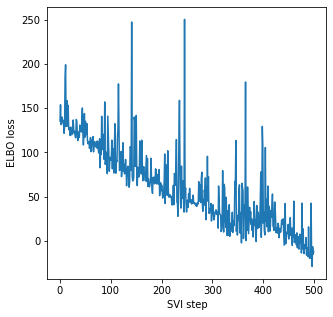

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [11]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha 0.92303956
AutoNormal.scales.alpha 0.04984102
AutoNormal.locs.beta 0.0028457497
AutoNormal.scales.beta 0.0032761802
AutoNormal.locs.sigma -3.9357777
AutoNormal.scales.sigma 0.15415098
